# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import sys
sys.path.insert(0, "/home/cornelius/mlagents/reacher/mlagents/")


from unityagents import UnityEnvironment
import numpy as np
np.set_printoptions(precision=3)

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
#env = UnityEnvironment(file_name="/home/cornelius/mlagents/deep-reinforcement-learning/p3_collab-compet/Tennis_Linux/Tennis.x86_64") #local
#env = UnityEnvironment(file_name="/home/cornelius/mlagents/deep-reinforcement-learning/p3_collab-compet/Tennis_Linux_NoVis/Tennis.x86_64") #local
env = UnityEnvironment(file_name="/home/cornelius/mlagents/tennis/Tennis_Linux_NoVis/Tennis.x86_64") #remote
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Found path: /home/cornelius/mlagents/tennis/Tennis_Linux_NoVis/Tennis.x86_64
Mono path[0] = '/home/cornelius/mlagents/tennis/Tennis_Linux_NoVis/Tennis_Data/Managed'
Mono config path = '/home/cornelius/mlagents/tennis/Tennis_Linux_NoVis/Tennis_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/cornelius/.config/unity3d/Unity Technologies/Unity Environment/Player.log


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])
print ('rewards:', env_info.rewards)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    -6.653 -1.5   -0.     0.
  6.832  6.    -0.     0.   ]
The state for the second agent looks like: [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    -6.467 -1.5    0.     0.
 -6.832  6.     0.     0.   ]
rewards: [0.0, 0.0]


When finished, you can close the environment.

In [4]:
from collections import deque
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class PrioritizedReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed, alpha=0.6, beta_start=0.4, beta_frames=100000, device='cpu'):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.buffer = []
        self.pos = 0
        self.priorities = np.ones(buffer_size, dtype=np.float32) * 1 / buffer_size
        self.beta = beta_start
        self.frame = 1
        self.device = device

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(e)
        else:
            self.buffer[self.pos] = e
        self.priorities[self.pos] = self.priorities.max() if self.buffer else 1.0
        self.pos = (self.pos + 1) % self.buffer_size

    def sample(self, beta=None):
        if beta is None:
            beta = self.beta
        if len(self.buffer) == self.buffer_size:
            priors = self.priorities
        else:
            priors = self.priorities[:self.pos]
        probs  = priors ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), self.batch_size, p=probs)
        experiences = [self.buffer[idx] for idx in indices]
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        
        return (states, actions, rewards, next_states, dones), indices, torch.from_numpy(weights).float().to(self.device)

    def update_priorities(self, indices, priorities):
        self.priorities[indices] = priorities.data.cpu().numpy().squeeze() + 1e-5

    def __len__(self):
        return len(self.buffer)

    def update_beta(self):
        self.beta = min(1.0, self.beta_start + self.frame * (1.0 - self.beta_start) / self.beta_frames)
        self.frame += 1
        

/home/cornelius/anaconda3/envs/mlagents/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3. Train the agent

Now it's time to train the agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [9]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque
import copy
import time

print_every = 10

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-3              # for soft update of target parameters
LR_ACTOR = 3e-3         # learning rate of the actor 
LR_CRITIC = 3e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY=1
NUM_UPDATES=1


TRAIN_MODE = True

training_epoch = 0

# increased batch_size to 64
# add oscillation to noise
# add batch normalization to actor and critic
# add weight decay to critic
# add dropout to critic
# use sklearn scaler to normalize states
# added prioritized experience replay based on reward
# changed batch size from 32 to 128
# changed learning rate from .001 to .003 and fc2 units from 256 to 128
# took out dropout layer
# moved batch normalization to after activation function -> highest score: .13
# adding individual reward to memory instead of maximum reward
# implemented prioritized experience replay

class dppg_agent():
    def __init__(self, state_size, action_size, random_seed, actor_fc1_units=256, actor_fc2_units=128, critic_fcs1_units=256, critic_fc2_units=128, device="cpu"):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random_seed
        self.actor_fc1_units = actor_fc1_units
        self.actor_fc2_units = actor_fc2_units
        self.critic_fcs1_units = critic_fcs1_units
        self.critic_fc2_units = critic_fc2_units
        self.buffer_size = BUFFER_SIZE
        self.batch_size = BATCH_SIZE
        self.actor_lr = LR_ACTOR
        self.critic_lr = LR_CRITIC
        self.weight_decay = WEIGHT_DECAY
        self.gamma = GAMMA
        self.tau = TAU
        self.device = device
        self.seed = random_seed
        self.actor_local = Actor(state_size, action_size, random_seed, actor_fc1_units, actor_fc2_units).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed, actor_fc1_units, actor_fc2_units).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.actor_lr)
        self.critic_local = Critic(state_size, action_size, random_seed, critic_fcs1_units, critic_fc2_units).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, critic_fcs1_units, critic_fc2_units).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=self.critic_lr, weight_decay=self.weight_decay)
        self.noise = OUNoise(action_size, random_seed)
        self.t_step = 0
        
    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)
    
    def reset(self):
        self.noise.reset()

    def learn(self, experiences, indices, weights, gamma):
        global training_epoch
        
        states, actions, rewards, next_states, dones = experiences
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)

        critic_loss = (weights * F.mse_loss(Q_expected, Q_targets)).mean()

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)
        training_epoch += 1
        return (Q_targets - Q_expected).abs().detach()
        


    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class MultiAgent():
    def __init__(self, n_agents, state_size, action_size, random_seed, device):
        self.n_agents = n_agents
        self.agents = [dppg_agent(state_size, action_size, random_seed, device=device) for _ in range(n_agents)]
        self.memory = PrioritizedReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed, device=device)
        self.t_step = 0
        self.device = device
        self.learning_episode = 0

    def act(self, states, add_noise=True):
        actions = [agent.act(states[idx], add_noise) for idx, agent in enumerate(self.agents)]
        return actions
    
    def step(self, states, actions, rewards, next_states, dones):
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, np.sum(rewards), next_state, done) #add the rewards of all agents together to promote cooperation
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                for _ in range(NUM_UPDATES):
                    # retrieve experiences from the memory
                    experiences, indices, weights = self.memory.sample()
                    self.learn(experiences, indices, weights, GAMMA)
    
    def learn(self, experiences, indices, weights, gamma):
        for agent in self.agents:
            delta = agent.learn(experiences, indices, weights, gamma)
            self.memory.update_priorities(indices, delta)
            self.memory.update_beta()
        self.learning_episode += 1

    def reset(self):
        for agent in self.agents:
            agent.reset()
        
class OUNoise:
    def __init__(self, size, seed, mu=0., theta=0.06, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        #return np.random.normal(0, .2, action_size) * np.sin(training_epoch * .001)
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([(random.random() - .5) for i in range(len(x))])
        self.state = x + dx
        return self.state
    
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(num_features=fc1_units)        
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(num_features=fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn3 = nn.BatchNorm1d(num_features=action_size)

        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = self.bn1(F.relu(self.fc1(state)))
        x = self.bn2(F.relu(self.fc2(x)))
        return nn.Tanh()(self.fc3(x))
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(num_features=fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.bn2 = nn.BatchNorm1d(num_features=fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = self.bn1(F.relu(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu((self.fc2(x)))
        return self.fc3(x)
        
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = MultiAgent(n_agents=2, state_size=24, action_size=2, random_seed=2, device=device)
scores_window = deque(maxlen=100)  # last 100 scores
avg_score_list = []
n_episodes = 2000
action_log = []
for i_episode in range(1, n_episodes + 1):
    env_info = env.reset(train_mode=TRAIN_MODE)[brain_name]
    agent.reset()
    states = env_info.vector_observations   # get the next state
    states = states / 30
    accumulated_reward = 0
    scores = []
    for t in range(1000):
        actions = agent.act(states)
        action_log.append(actions)
        env_info = env.step(actions)[brain_name]        # send the action to the environment
        next_states = env_info.vector_observations   # get the next state
        next_states = next_states / 30
        rewards = env_info.rewards                      # get the reward
        accumulated_reward += rewards[0]
        dones = env_info.local_done                    # see if episode has finished
        agent.step(states, actions, rewards, next_states, dones)                     
        scores.append(rewards)                               # update the score
        states = next_states                             # roll over the state to next time step
        if np.any(dones):                               # exit loop if episode finished
            break
    
    score = np.max(np.sum(scores, axis=0))
    scores_window.append(score)
    avg_score_list.append(np.mean(scores_window))

    print(
        "\rEpisode {}\tCurrent score: {:.2f}, Average score: {:.2f}, noise factor {:.2f}, learning episode: {}, memory size: {}, max delta: {:.2f}".format(
            i_episode, score, np.mean(scores_window), np.sin(training_epoch * .001), agent.learning_episode, agent.memory.__len__(), np.max(agent.memory.priorities)
        ))

    if np.mean(scores_window) >= .5:
        print(
            "\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}".format(
                i_episode - 100, np.mean(scores_window)
            )
        )
        for idx, agent in enumerate(agent.agents):
            torch.save(agent.actor_local.state_dict(), "checkpoint_actor"+str(idx)+".pth")
            torch.save(agent.critic_local.state_dict(), "checkpoint_critic"+str(idx)+".pth")
        break
    

Episode 1	Current score: 0.00, Average score: 0.00, noise factor 0.00, learning episode: 0, memory size: 66, max delta: 0.00
Episode 2	Current score: 0.00, Average score: 0.00, noise factor 0.00, learning episode: 0, memory size: 94, max delta: 0.00
Episode 3	Current score: 0.00, Average score: 0.00, noise factor 0.00, learning episode: 0, memory size: 122, max delta: 0.00
Episode 4	Current score: 0.00, Average score: 0.00, noise factor 0.02, learning episode: 12, memory size: 152, max delta: 0.06
Episode 5	Current score: 0.00, Average score: 0.00, noise factor 0.05, learning episode: 26, memory size: 180, max delta: 0.04
Episode 6	Current score: 0.00, Average score: 0.00, noise factor 0.08, learning episode: 40, memory size: 208, max delta: 0.04
Episode 7	Current score: 0.00, Average score: 0.00, noise factor 0.11, learning episode: 54, memory size: 236, max delta: 0.04
Episode 8	Current score: 0.00, Average score: 0.00, noise factor 0.14, learning episode: 68, memory size: 264, max d

### 4. Visualize training progress
Display average rewards received over past 100 episodes

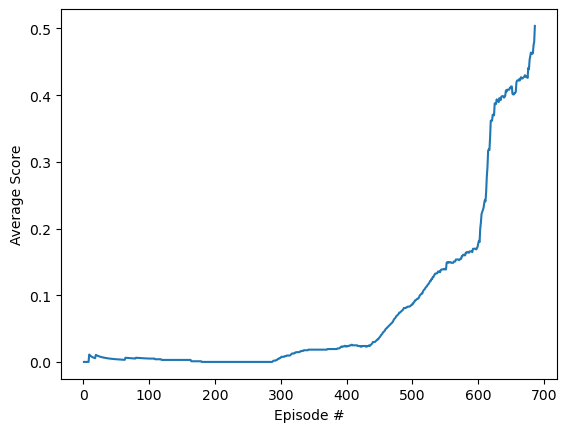

In [10]:
# plot the scores
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(avg_score_list) + 1), avg_score_list)
plt.ylabel("Average Score")
plt.xlabel("Episode #")
plt.show()


### 5. Examine actions agent chose within action space
As notable in the folllowing chart, the agent prefers actions on edges of the action space

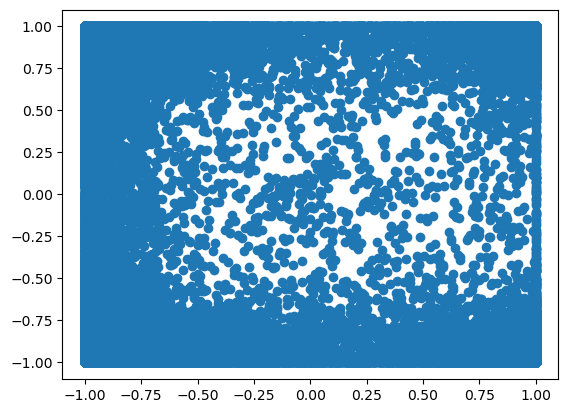

In [19]:
action_log = np.array(action_log).squeeze()
x, y = action_log[:, 0, :].T
# plot
#plt.figure(figsize=(10, 10))
plt.scatter(x, y)
plt.show()
